In [2]:
from karateclub.dataset import GraphSetReader
from karateclub import FeatherGraph, Graph2Vec, IGE, GeoScattering, GL2Vec, NetLSD, SF, FGSD
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
import networkx as nx
import torch
import itertools
import numpy as np
import random

In [3]:
protein_data = TUDataset(r'C:\Users\16sic\Documents\GitHub\conference_draft\src\\', r'PROTEINS')

In [4]:
protein_data = protein_data.shuffle()
get_all_edge = [data.edge_index for data in protein_data]
get_all_edget = [np.vstack((x,y)).T for x,y in get_all_edge]
newedgelist = []
for x in range(len(get_all_edget)):
    G = nx.Graph()
    G.add_edges_from(get_all_edget[x])
    newedgelist.append(G)
get_all_target = [data.y.item() for data in protein_data]

In [5]:
reader = GraphSetReader("reddit10k") #  two types - discussion and non-discussion based ones.
graphlist = reader.get_graphs()[:100]
targetlist = reader.get_target()[:100]

In [6]:
reddit_bag = [(x, y) for x, y in zip(graphlist, targetlist)]
protein_bag = [(x,y) for x,y in zip(newedgelist, get_all_target)]

In [7]:
scaler = StandardScaler()

X_train = [x for x, y in reddit_bag][:10]
y_train = [y for x, y in reddit_bag][:10]
model = FeatherGraph()
model.fit(X_train)
train_embed = model.get_embedding()
train_embed = scaler.fit_transform(train_embed)

X_validation = [x for x, y in reddit_bag][11:51]
y_validation = [y for x, y in reddit_bag][11:51]

X_test = [x for x, y in reddit_bag][52:71]
y_test = [y for x, y in reddit_bag][52:71]
model = FeatherGraph()
model.fit(X_test)
test_embed = model.get_embedding()
test_embed = scaler.fit_transform(test_embed)

X_anmaly = [x for x, y in protein_bag][:3]
Y_anmaly = [y for x, y in protein_bag][:3]
model = FeatherGraph()
model.fit(X_anmaly)
anomaly_embed = model.get_embedding()
anomaly_embed = scaler.fit_transform(anomaly_embed)

Text(0, 0.5, 'Spend_Score')

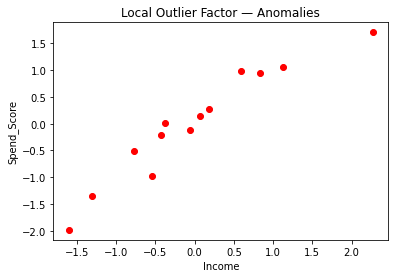

In [10]:
np.random.seed(42)

# Generate train data
X_inliers = train_embed

# Generate some outliers
X_outliers = anomaly_embed
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.01)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()